<a href="https://colab.research.google.com/github/jungyoojang/MachineLearning/blob/main/8_2_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류

**완전 연결 신경망 vs 합성곱 신경망**

완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일열로 펼쳐야 했으나

합성곱 신경망에서는 2차원 이미지를 그대로 이용하므로 펼치지 않음

다만 입력 이미지는 항상 깊이(채널)이 있어야 하므로 채널 차원을 추가함

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 패션 MNIST 데이터 불러오기

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
# 데이터 불러오기
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
# 정규화
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# 훈련셋에서 검증셋 나누기
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


하나의 이미지에 대한 깊이(채널) 차원을 넣어주어 (48000,28,28) 크기인 train_input(3차원 배열)이 (48000,28,28,1) 크기인 train_scaled(4차원 배열) 되었다.

## 합성곱 신경망 만들기

In [ ]:
model = keras.Sequential()

첫 번째 합성곱 층

In [ ]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1))
# 32개의 필터 / 커널크기 (3,3) / 활성함수 relu / 세임 패딩

In [ ]:
model.add(keras.layers.MaxPooling2D(2)) # 풀링 층 추가

두 번째 합성곱 - 풀링 층 추가

In [ ]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

두 번째 합성곱 층 + 완전 연결 층

과대적합을 막기 위해 드롭다운을 추가

In [ ]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

**모델 파라미터 수를 계산해보자**

첫 번째 합성곱 층은 (3,3,1) 크기의 32개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3 * 3 * 1 * 32 + 32 = 320

두 번째 합성곱 층은 (3,3,32) 크기의 64개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3 * 3 * 32 * 62 + 32 = 18496

Flatten 층에서 (7,7,64)크기의 특성 맵을 1차원 배열로 펼치면 7 * 7 * 64 = 3136 크기의 배열이 됨

이를 100개의 뉴런과 완전히 연결해야 하므로 은닉층의 모델 파라미터 개수는 3136 * 100 + 100 = 313700

마지막 출력층은 100 * 10 + 10 = 1010

**층의 구성을 그림으로 표현해보자**

왼쪽에는 층의 이름이, 오른쪽에는 클래스가 나타난다.

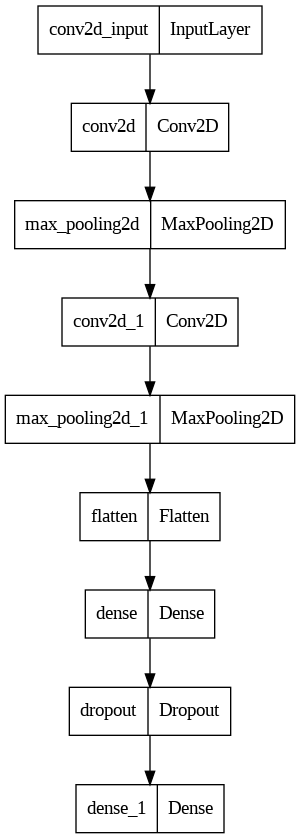

In [ ]:
keras.utils.plot_model(model)

입력과 출력의 크기도 같이 출력해보자

- show_shapes 매개변수 = True

- to_file: 파일 이름을 지정하면 출력한 이미지를 파일로 저장함 (기본값 to_file = model.png)

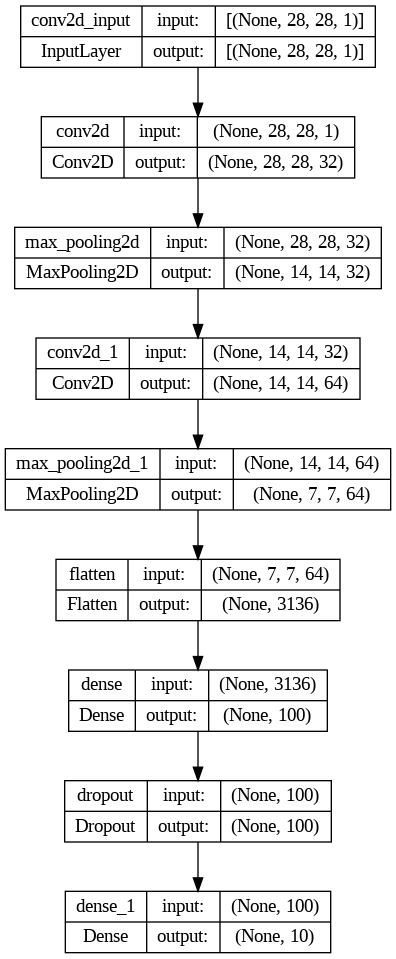

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

**지금까지 만든 신경망**
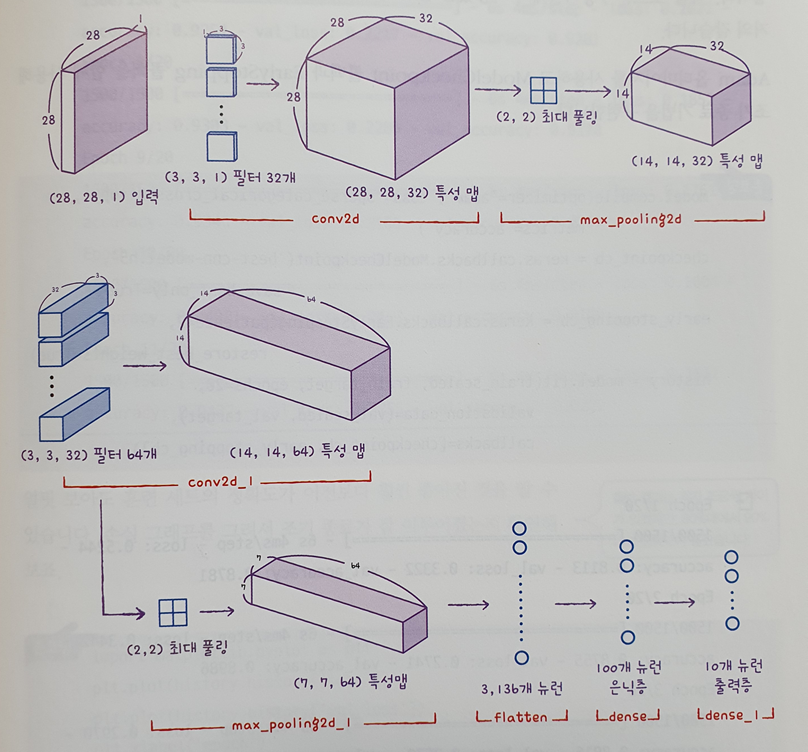

## 모델 컴파일과 훈련

케라스 API의 장점은 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy') # 옵티마이저, 손실함수, 측정항목
# 콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
# 훈련 객체 저장
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 20s 4ms/step - loss: 0.5091 - accuracy: 0.8178 - val_loss: 0.3178 - val_accuracy: 0.8823
Epoch 2/20
  25/1500 [..............................] - ETA: 6s - loss: 0.3597 - accuracy: 0.8712

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 7s 5ms/step - loss: 0.3382 - accuracy: 0.8775 - val_loss: 0.2747 - val_accuracy: 0.8964
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2927 - accuracy: 0.8945 - val_loss: 0.2451 - val_accuracy: 0.9101
Epoch 4/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2583 - accuracy: 0.9064 - val_loss: 0.2343 - val_accuracy: 0.9131
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2358 - accuracy: 0.9134 - val_loss: 0.2234 - val_accuracy: 0.9160
Epoch 6/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2151 - accuracy: 0.9211 - val_loss: 0.2149 - val_accuracy: 0.9220
Epoch 7/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1982 - accuracy: 0.9268 - val_loss: 0.2145 - val_accuracy: 0.9202
Epoch 8/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1810 - accuracy: 0.9336 - val_loss: 0.2196 - val_accuracy: 0.9222
Epo

성능 평가

In [ ]:
import matplotlib.pyplot as plt

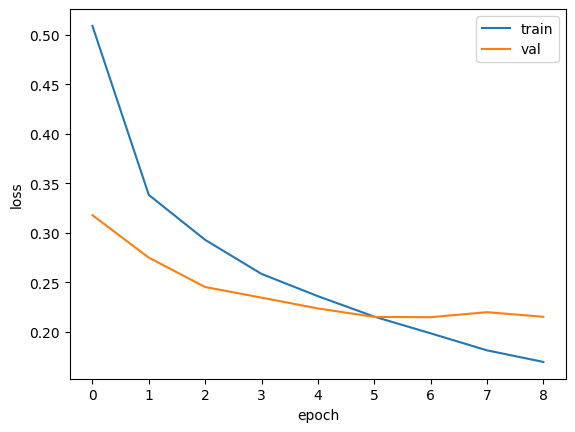

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

에포크가 7인 지점에서 검증 셋의 손실점수가 저점을 찍고 올라가고 있다.
patience=2이므로 9에서도 손실점수가 상승하여 에포크 9에서 조기 종료한것으로 보인다.
따라서 7번째 에포크가 최적의 모델이라고 할 수 있다.



EarlyStoppig 클래스에서 restore_best_weight 매개변수를 True로 지정했으므로 현재 model 객체에 최적의 모델 파라미터로 복원되어 있음

즉, ModelCheckPoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음

세트에 대한 성능 평가

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.2145 - accuracy: 0.9202


[0.21453545987606049, 0.9201666712760925]

fit() 메서드의 출력 중 일곱번째 에포크의 출력과 동일한 것으로 보아.
EarlyStopping 콜백이 model 객체를 최적의 모델 파라미터로 잘 복원하였다

첫 번째 검증 데이터를 확인해보자

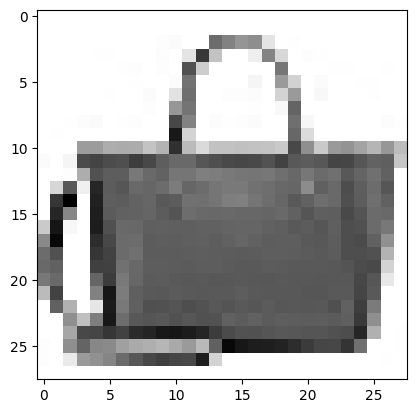

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

첫 번째 검증 데이터를 예측해보자

In [ ]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 116ms/step
[[3.3830289e-14 1.6479672e-22 2.1887265e-18 1.7189894e-15 6.0608955e-14
  2.9962747e-12 7.4386124e-13 8.6856405e-14 1.0000000e+00 1.9710426e-14]]


9번째 클래스의 값이 1에 가깝고 나머지는 0에 수렴한다.

**슬라이싱한 이유**

predict() 메서드에 데이터를 전달할 때 val_scaled[0]가 아닌 val_scaled[0:1]와 같이 슬라이싱함

그 이유는 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원으로 생각하기 떄문임

따라서 샘플 하나를 전달할 떄는 (28,28,1)이 아니라 (1,28,28,1)크기를 전달해야함

배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1)크기를 만듦

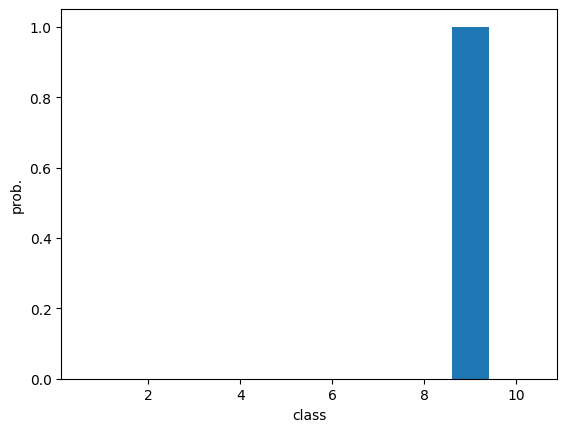

In [ ]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
import numpy as np
print(classes[np.argmax(preds)])

가방


테스트 샘플에 대한 예측을 수행하자

In [ ]:
# 정규화
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
# 성능 평가
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2394 - accuracy: 0.9141


[0.23940542340278625, 0.9140999913215637]

test set의 결과 0.9179는 val set의 결과 0.9223보다 조금 더 작다.
해당 모델을 실전 투입 시에는 약 91%의 성능을 보일 것이다.